# Generating a set of Total Field anomaly data for a model

Notebook to open a dictionary with the Total Field Anomaly data for a set of geometrical objects.

#### Import libraries

In [1]:
%matplotlib inline
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime

from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, Prism,PolygonalPrism
from fatiando.gravmag import sphere,prism, polyprism

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
notebook_name = 'synthetic_data.ipynb'

#### Importing auxiliary functions

In [3]:
dir_modules = '../../../mypackage'
sys.path.append(dir_modules)

In [4]:
import auxiliary_functions as func

#### Loading properties of a set of geometrical objects

In [5]:
with open('data/model_multi.pickle') as f:
        model_multi = pickle.load(f)

#### Loading the grid parameters

In [6]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Constructing a dictionary

In [7]:
data_set = dict()

#### List of saved files

In [8]:
saved_files = []

## Properties of the model

## Main field

In [9]:
inc_gf,dec_gf = model_multi['main_field']

In [10]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: -40.0 degree
Main field declination: -20.0 degree


## Magnetization Direction

### Direction w/ the presence of remanent magnetization

In [11]:
print 'Inclination: %.1f degree' % model_multi['inc_R']
print 'Declination: %.1f degree' % model_multi['dec_R']

Inclination: 5.0 degree
Declination: 5.0 degree


In [12]:
inc_R,dec_R = model_multi['inc_R'],model_multi['dec_R']

## Calculating the data

### For Airborne survey

#### Observation area

In [13]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1],airborne['area'][0],
                                                                                                airborne['area'][3],airborne['area'][2])

Area limits: 
 x_max = 6000.0 m 
 x_min = -6000.0 m 
 y_max = 6000.0 m 
 y_min = -6000.0 m


#### Airborne survey information

In [14]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']
print 'Height: %.1f m' % airborne['z_obs']

Shape : (50,25)
Number of data: 1250.0
dx: 244.9 m
dy: 500.0 m 
Height: -100.0 m


#### Calculating the data

In [15]:
data_set['tfa_RM_airb_poly'] = polyprism.tf(airborne['x'],airborne['y'],airborne['z'],
                                          model_multi['polygons'],inc_gf,dec_gf)

In [16]:
data_set['tfa_RM_airb_sph'] = sphere.tf(airborne['x'],airborne['y'],airborne['z'],
                                          model_multi['spheres'],inc_gf,dec_gf)

In [17]:
data_set['tfa_RM_airb_dip'] = prism.tf(airborne['x'],airborne['y'],airborne['z'],
                                          model_multi['dip'],inc_gf,dec_gf)

In [18]:
data_set['tfa_RM_airb'] = data_set['tfa_RM_airb_poly'] + data_set['tfa_RM_airb_sph'] + data_set['tfa_RM_airb_dip']

##### Generating noise for the data set w/ remanet magnetization presence

In [19]:
np.random.seed(seed=40)

In [20]:
std_noise = 20.
r = np.random.normal(0.0,std_noise, airborne['Nx']*airborne['Ny'])
data_set['tfa_obs_RM_airb'] =  data_set['tfa_RM_airb'] + r

#### Visualization of Total Field Anomaly for airborne survey w/ the presence of Remanent magnetization in a polyprism

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


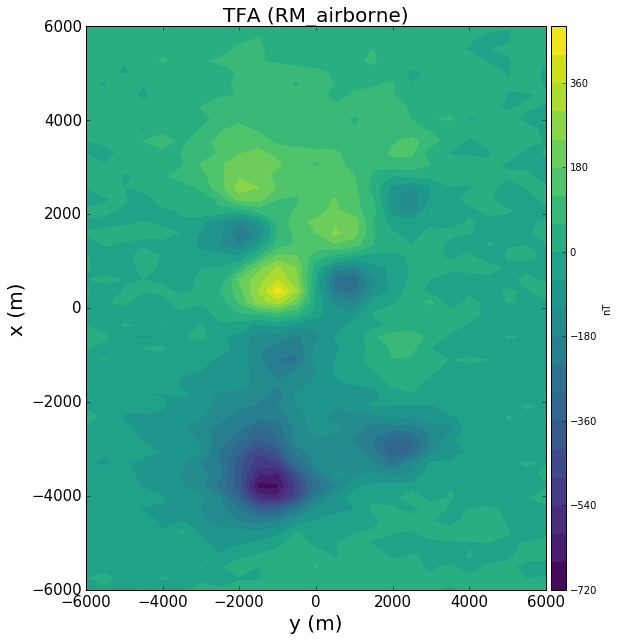

In [21]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             data_set['tfa_obs_RM_airb'].reshape(airborne['shape']), 
             20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RM_airborne)', fontsize=title_font)
plt.tick_params(labelsize=15)

file_name = 'figs/airborne/noisy_data_tfa_RM_airborne_multi'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=200)
saved_files.append(file_name+'.eps')


plt.show()

#### Generating .pickle file

In [22]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
data_set['metadata'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [23]:
file_name = 'data/data_set.pickle'
with open(file_name, 'w') as f:
    pickle.dump(data_set, f)
    
saved_files.append(file_name)


## Saved files

In [24]:
with open('reports/report_%s.md' % notebook_name[:st.index(notebook_name, '.')], 'w') as q:
    q.write('# Saved files \n')
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
    q.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        q.write('*  `%s` \n' % (sf))

1  figs/airborne/noisy_data_tfa_RM_airborne_multi.png
2  figs/airborne/noisy_data_tfa_RM_airborne_multi.eps
3  data/data_set.pickle
